# U-NET

Run in the docker image found in https://github.com/waspinator/deep-learning-explorer


In [1]:
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

import sys
import random
import math
import re
import time
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

sys.path.insert(0, '../libraries')
import semantic.weights
import semantic.utils
import semantic.config
import semantic.coco
import semantic.unet
import semantic.generator
import semantic.visualize


HOME_DIR = '/home/keras'
DATA_DIR = os.path.join(HOME_DIR, "data/shapes")
WEIGHTS_DIR = os.path.join(HOME_DIR, "data/weights")
MODEL_DIR = os.path.join(DATA_DIR, "logs")

Using TensorFlow backend.


# Dataset

Your data should be in the [COCO style format](http://cocodataset.org/#download).

Organize the dataset using the following structure:

```
DATA_DIR
│
└───annotations
│   │   instances_<subset><year>.json
│   
└───<subset><year>
    │   image021.jpeg
    │   image022.jpeg
```

In [4]:
dataset_train = semantic.coco.CocoDataset()
dataset_train.load_coco(DATA_DIR, subset="shapes_train", year="2018")
dataset_train.prepare()

dataset_validate = semantic.coco.CocoDataset()
dataset_validate.load_coco(DATA_DIR, subset="shapes_validate", year="2018")
dataset_validate.prepare()

dataset_test = semantic.coco.CocoDataset()
dataset_test.load_coco(DATA_DIR, subset="shapes_test", year="2018")
dataset_test.prepare()

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
dataset_train.class_info

[{'source': '', 'id': 0, 'name': 'BG'},
 {'source': 'coco', 'id': 1, 'name': 'square'},
 {'source': 'coco', 'id': 2, 'name': 'circle'},
 {'source': 'coco', 'id': 3, 'name': 'triangle'}]

In [6]:
dataset_train.class_weight 

{0: 0.6245757457188198,
 1: 0.16082110268729075,
 2: 0.1188858904157366,
 3: 0.09571726117815291}

# Configuration

In [7]:
class UnetConfig(semantic.unet.Config):

    NAME = "unet"
    
    TRAIN_DATASET_SIZE = len(dataset_train.image_ids)
    BATCH_SIZE = 1
    VALIDATION_STEPS = 10
    STEPS_PER_EPOCH = 100
    
    CLASSES = 1 + 3 # background + three shapes
    IMAGE_HEIGHT = 512
    IMAGE_CHANNELS = 3
    
    
config = UnetConfig()
config.display()


Configurations:
BATCH_SIZE                     1
CLASSES                        4
IMAGE_CHANNELS                 3
IMAGE_HEIGHT                   512
IMAGE_SHAPE                    (512, 512, 3)
IMAGE_WIDTH                    512
NAME                           unet
STEPS_PER_EPOCH                100
TRAIN_DATASET_SIZE             700
VALIDATION_STEPS               10




### Visualize original data

In [9]:
image_ids = np.random.choice(dataset_train.image_ids, 4)

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    #semantic.visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    #semantic.visualize.display_class_mask(mask, class_ids, dataset_train.class_names)

In [10]:
image = dataset_train.load_image(1)
mask, class_ids = dataset_train.load_mask(1)
semantic.visualize.display_classes(mask, class_ids, dataset_train.class_names)

(512, 512, 0)
(512, 512, 2)
(512, 512, 1)
(512, 512, 2)


### Visualize data passed in to the model

Images are standardized and augmented before being passed in for training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


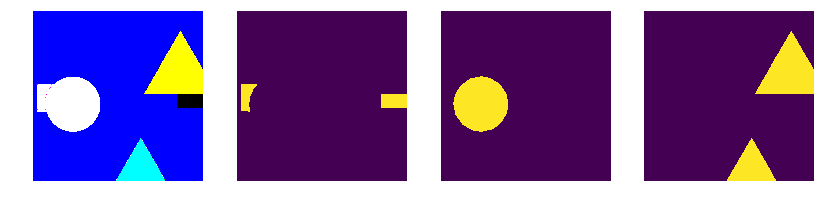

In [12]:
data_generator = semantic.generator.CocoGenerator(
    pixel_mean=(123.68, 116.779, 103.939),
    pixelwise_center=True
)

generator_train = data_generator.flow_from_dataset(
    dataset_train,
    target_size=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
    batch_size=config.BATCH_SIZE,
    classes=config.CLASSES
)

semantic.visualize.display_generator_output(generator_train, [1])

# Load Model

In [13]:
model = semantic.unet.Unet(config=config, model_dir=MODEL_DIR)

In [14]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_contracting_conv_a (Conv (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_contracting_conv_b (Conv (None, 512, 512, 64) 36928       block1_contracting_conv_a[0][0]  
__________________________________________________________________________________________________
block1_contracting_pool (MaxPoo (None, 256, 256, 64) 0           block1_contracting_conv_b[0][0]  
__________________________________________________________________________________________________
block2_con

## Load weights

In [12]:
weights_path = semantic.utils.find_last(config, MODEL_DIR)[1]
model.keras_model.load_weights(weights_path, by_name=True)

## Train head

Train using only the head

In [15]:
model.train(dataset_train, dataset_validate,
            learning_rate=0.01,
            epochs=1,
            layers='all')

block1_contracting_conv_a   (Conv2D)
block1_contracting_conv_b   (Conv2D)
block2_contracting_conv_a   (Conv2D)
block2_contracting_conv_b   (Conv2D)
block3_contracting_conv_a   (Conv2D)
block3_contracting_conv_b   (Conv2D)
block4_contracting_conv_a   (Conv2D)
block4_contracting_conv_b   (Conv2D)
block5_contracting_conv_a   (Conv2D)
block5_contracting_conv_b   (Conv2D)
block6_expanding_conv_up   (Conv2D)
block6_expanding_conv_a   (Conv2D)
block6_expanding_conv_b   (Conv2D)
block7_expanding_conv_up   (Conv2D)
block7_expanding_conv_a   (Conv2D)
block7_expanding_conv_b   (Conv2D)
block8_expanding_conv_up   (Conv2D)
block8_expanding_conv_a   (Conv2D)
block8_expanding_conv_b   (Conv2D)
block9_expanding_conv_up   (Conv2D)
block9_expanding_conv_a   (Conv2D)
block9_expanding_conv_b   (Conv2D)
class_output           (Conv2D)
Epoch 1/1
100/100 [==============================] - 33s 328ms/step - loss: 0.7524 - categorical_accuracy: 0.6137 - val_loss: 0.6169 - val_categorical_accuracy: 0.6854


## Fine tune

Train more slowly than before but using all the layers. Starts from the previous epoch. For example if you set the train part to have 4 epochs and you want to fine tune for 2, set the epochs below to 6

In [ ]:
model.train(dataset_train, dataset_validate,
            learning_rate=0.001,
            epochs=6,
            layers='all')

# Predict

Predict on a sample image

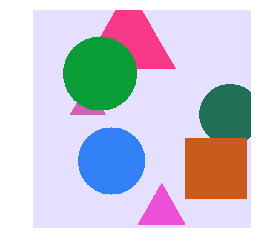

In [13]:
test_image_id = np.random.choice(dataset_test.image_ids, 1)[0]
image = Image.open(dataset_test.image_reference(test_image_id))
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(image)

In [14]:
prediction = model.predict(image)

IndexError: list index out of range

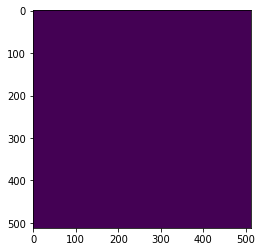

In [15]:
plt.figure(figsize=(8,4))
im = plt.imshow(prediction, interpolation='none')
values = np.unique(prediction.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ matplotlib.patches.Patch(color=colors[i], label="{}".format(dataset_test.class_info[i]['name'])) for i in values ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='x-large')
plt.axis('off')
plt.show()

# Evaluate

Get the Mean IoU for each class in the dataset

In [ ]:
semantic.evaluate.evaluate(model, dataset_test)

In [ ]:
semantic.utils.result_to_coco(prediction, dataset_test.class_info, config.IMAGE_MAX_DIM, config.IMAGE_MAX_DIM)